In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister ,execute, Aer
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes
from qiskit.primitives import Estimator, Sampler
from qiskit_algorithms.minimum_eigensolvers import VQE 
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit.quantum_info import SparsePauliOp, Pauli, state_fidelity, random_statevector
from qiskit.extensions import RZGate, UnitaryGate
from qiskit.quantum_info import Operator, Statevector
from numpy import sqrt, diag, array,conjugate,transpose, append, dot, abs, pi, linalg, log, sqrt,arange, mean, std, exp
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from random import *

# Calculation of 2-nd Renyi entanglement entropy

In [2]:
# Number of sites
N = 2
# Reduced region (list of qubits) to calculate reduced density matrix
A = [0]
# Create a random quantum state
state_list = random_statevector(2**N,seed=100)

**Matrix representation of JW transformation**

Jordan-Wigner transformation is defined: $$\phi_n = \prod_{l<n}\left(i\sigma^Z_l\right)\sigma^-_n.$$
Our purpose is finding uinirary operator represetation of JW transformation such that $$U_{JW}\ket{Lattice} = \ket{Spin}.$$ For example for 2-modes lattice, we have $$\ket{00} \rightarrow \ket{\downarrow \downarrow}$$ 
$$\ket{10}  = \phi^\dagger_2 \ket{00} \rightarrow \prod_{l<2}\left(-i \sigma^z_l \right) \sigma_2^+ \ket{\downarrow \downarrow} = i\ket{\uparrow \downarrow}$$
$$\ket{01}  = \phi^\dagger_1 \ket{00} \rightarrow  \sigma_1^+ \ket{\downarrow \downarrow} = \ket{\downarrow \uparrow}$$
$$\ket{11}  = \phi^\dagger_1 \phi^\dagger_2 \ket{00} \rightarrow \sigma_1^+ \prod_{l<2}\left(-i \sigma^z_l \right) \sigma_2^+ \ket{\downarrow \downarrow}= i \ket{\uparrow \uparrow}$$
Then, we have a diagonal form of JW transformation operator $$\left[U^2_{JW}\right]_{\alpha,i}=Diag\left(1,1,i,i\right),$$
where $\alpha \equiv$ spin chain basis and $i \equiv$ lattice basis. The generalization for N-modes lattice of JW operator 
$$\left[U^N_{JW}\right]_{\alpha,i} = \left[U^{N-1}_{JW}\right]_{\alpha,i}\oplus i^{N-1} \left[U^{N-1}_{JW}\right]_{\alpha,i},$$
where $Diag(a_1,\dots, a_n) \oplus Diag(b_1,\dots,b_m) = Diag(a_1,\dots, a_n,b_1,\dots,b_m)$ and $\left[U^1_{JW}\right]_{\alpha,i} = \mathbb{I}_{2x2}$.

In [3]:
# Create a Jordan Wigner transformation matrix U_JW |SP> -> |SW>
def gate_JW(N):
   JWM = array([1,1])
   for i in range(1,N):
      JWM = append(JWM ,(-1j)**(i)*JWM)
   # Change the order because we assigned |00..0>_sc = |11..1>_sp
   JWM = list(reversed(JWM))
   # Create diagonal JW transformation matrix 
   Uni_JW = diag(JWM)
   # Put into gate representation
   gate_JW = UnitaryGate(Uni_JW,label='JW')
   return gate_JW

Apply JW transformation to work in Schwinger basis

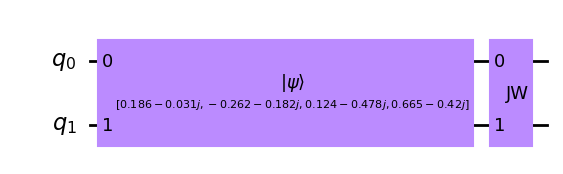

In [40]:
qc = QuantumCircuit(N)
# Initialize state
qc.initialize(state_list,qc.qubits)
# Aplly JW transformation operator
# qc.unitary(Uni_JW ,[ i for i in range(N)],label='JW')
qc.append(gate_JW(N),[ i for i in range(N)])
qc.draw('mpl')

Built  $|\psi\rangle$ and $\langle\psi|$ circuits

In [41]:
# Transpile circuit to basic gates
tran_qc = transpile(qc,basis_gates=['cx','rz','rx','ry'])
# Combine into one state representation
State=tran_qc.to_gate(label=r' $|\psi\rangle$ ')
# Create the conjugate state
conjState=tran_qc.inverse().to_gate(label=r' $\langle\psi|$ ')

**SWAP gate measurement of calculating 2-nd Renyi EE**

nth-Renyi Entanglement Entropy is defined
$$S^n_A = \frac{1}{1-n}Tr\left(\rho^n_A\right),$$ 
when $n \rightarrow 1$ then $S^n \rightarrow S_A = -Tr\left[\rho_A log\left(\rho_A\right)\right]$ called Von Neumann entropy. To calculate the n-th Renyi entropy, the algorithm is formulated using replicated circuits $\ket{\psi} \rightarrow \left\{\ket{\psi_1},\ket{\psi_2},\dots, \ket{\psi_n}\right\}$ , and  SWAP_A gate which swap cicularly A-qubits in the replicated set of $\ket{\psi}$
$$S^n_A = \bra{\psi_n}\otimes\dots\otimes\bra{\psi_2}\otimes\bra{\psi_1} SWAP_A \ket{\psi_1}\otimes\ket{\psi_2}\otimes\dots\otimes\ket{\psi_n}.$$ 
In 2-nd Renyi entropy, we get
$$S^2_A = \bra{\psi_2}\otimes\bra{\psi_1} SWAP_A \ket{\psi_1}\otimes\ket{\psi_2}.$$ 

To deploy the SWAP method, duplicate circuit is needed

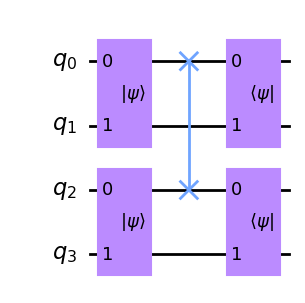

In [42]:
# Create douplicate circuit
totalqc = QuantumCircuit(2*N)
# Create the state 1
totalqc.append(State,[i for i in range(N)])
# Create the state 2
totalqc.append(State,[i for i in range(N,2*N)])
# Apply SWAP gate
for i in A:
    totalqc.swap(i,N+i)
# Create the conjugate state 1
totalqc.append(conjState,[i for i in range(N)])
# Create the conjugate state 2
totalqc.append(conjState,[i for i in range(N,2*N)])
totalqc.draw('mpl')

In [4]:
# circuit for measurementdef 
def meas(N):
    q = QuantumRegister(2*N,'q')
    c = ClassicalRegister(2*N)
    meas = QuantumCircuit(q,c)
    meas.measure(q[0:2*N],c[0:2*N])
    return meas

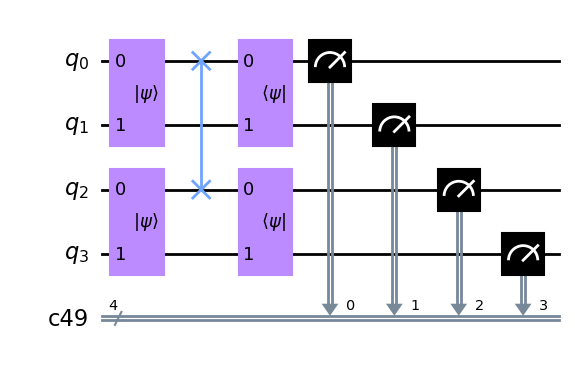

In [44]:
# Make measurement
totalqc_meas = totalqc.compose(meas(N))
totalqc_meas.draw('mpl')

*Get the squared absolute value of trace of squared reduced density matrix*

- Sampler backend running


In [45]:
# Use sampling backend to sample circuit
# Define how many samples to estimate
shot_times=10000
# Define the backend
simulator = Aer.get_backend('qasm_simulator')
# Execute circuit
job = execute(totalqc_meas, simulator,shots=shot_times)
# Get counts
result = job.result().get_counts(totalqc_meas)
# Define the bit string in computational basis (0,1)
bitstr0 = '0'*2*N
# Get probability
result[bitstr0]/shot_times

0.6674

- Exact probability calculation

In [46]:
# Get exactly probability
EE = Statevector(totalqc).probabilities([i for i in range(2*N)])[0]
print(EE)

0.6613582819789576


**Real Gate Implementation of JW transformation**

Because of being in pratical, a gate is composed of basic single qubit rotation gates, we thus have to implement JW transformation is terms of basic single qubit gates

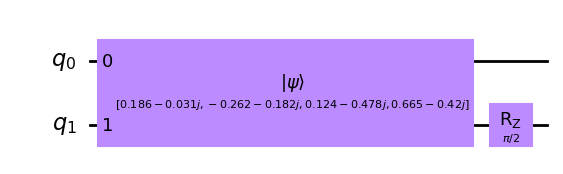

In [47]:
Cusqc = QuantumCircuit(N)
# Initialize a state
Cusqc.initialize(state_list,Cusqc.qubits)
# Apply JW transformation in terms of basis gate
for i in range(1,N):
   # Because JW transformation is simply a diagonal matrix, then we just simply do implement the phase rotaion RZ
   Cusqc.rz(i*pi/2,i)
Cusqc.draw('mpl')

Check fidelity between JW transformation matrix based gate and pratical gate

In [48]:
bitstr0 = '0'*N
inista = Statevector.from_label(bitstr0)
sv1 = inista.evolve(qc).data
sv2 = inista.evolve(Cusqc)
sv2 = conjugate(sv2.data)
abs(dot(sv2,sv1))

0.9999999999999998

Congrate !!! "1" means these are the same, and we implemented JW operator correctly

**Check 2-mode Schwinger model example in analytical calculation**

- Consider a state in spin chain basic:
$$ |\psi\rangle_{sp} = c_0|\uparrow\uparrow\rangle+c_1|\uparrow\downarrow\rangle+c_2|\downarrow\uparrow\rangle+c_3|\downarrow\downarrow\rangle, $$
after Jordan-Wigner transformation it gets the form
$$ U^\dagger_{JW}|\psi\rangle_{sp} = |\psi\rangle_{Sc} = -i c_0|11\rangle - i c_1|10\rangle+c_2|01\rangle+c_3|00\rangle , $$
where $$\left[U_{JW}\right]_{i\alpha} = \left(\begin{array}{c}1&0&0&0\\ 0&1&0&0 \\ 0&0&-i&0 \\ 0&0&0&-i\end{array}\right) $$ is a diagonal matrix in two bases, $i$ is the spin chain basis and $\alpha$ is the Schwinger basis.
- Choose the qubit 1 is to calculate reduced density matrix, then
$$\rho_A = \left(\begin{array}{c}|c_3|^2+|c_1|^2&c^*_0c_1+c^*_2c_3\\c_1c_0^*+c_2c_3^*&|c_0|^2+|c_2|^2\end{array}\right)$$
$$\Rightarrow \text{Tr}\left[\rho_A^2\right] = \sum_{i=0}^3\left(|c_i|^2\right)^2-2\left(|c_3|^2|c_0|^2+|c_2|^2|c_1|^2\right)+4\text(Re)\left(c_0^*c_1c_2c_3^*\right),$$
or the second order Renyi EE
$$ S^2_A = -\text{Log}\left[\sum_{i=0}^3\left(|c_i|^2\right)^2-2\left(|c_3|^2|c_0|^2+|c_2|^2|c_1|^2\right)+4\text(Re)\left(c_0^*c_1c_2c_3^*\right)\right]$$

In [49]:
# Implement the formula above
Tr_rho_2 = 0
for i in state_list:
    Tr_rho_2+=abs(i)**2
Tr_rho_2 = Tr_rho_2**2 + 4*(state_list[0].conjugate()*state_list[1]*state_list[2]*state_list[3].conjugate()).real - 2*abs(state_list[1])**2*abs(state_list[2])**2-2*abs(state_list[0])**2*abs(state_list[3])**2
print(Tr_rho_2**2)

0.6613582819789573


Compare the analytical calculation and the SWAP method in quantum computer

In [50]:
Tr_rho_2**2-EE

-3.3306690738754696e-16

$\approx 0 $, we are on the way 

# VQE for finding ground state of Schwinger model and calculate 2-nd Renyi EE

**Schwinger lattice model Hamiltonian**

$$H^{1D}_{Lattice} = -\frac{1}{2a}\sum_{n=1}^{N-1}\left(\hat{\phi}_n^\dagger e^{i\hat{\phi}_n}\hat{\phi}_{n+1}+ h.c.\right)+\frac{g^2 a}{2}\sum_{n=1}^{N-1} \hat{L}_{n,n+1} + \mu \sum_{n=1}^N (-1)^n\hat{\phi}_n^\dagger\hat{\phi}_n,$$
after Jordan-Wigner transformation $$\phi_n = \prod_{l<n}\left(i\sigma^Z_l\right)\sigma^-_n$$
and Gauss's law to eliminate gauge redundancy d.o.f. $$\hat{L}_{n,n+1}=\epsilon_0 + \frac{1}{2}\sum_{i=1}^n\left[\sigma^z_i+(-1)^i\right].$$
Finally, we get the Schwinger model Hamiltonian in Spin chain form $$H^{1D}_{Spin}= \frac{1}{2a}\sum_{n=1}^{N-1}\left(\hat{\sigma}_n^+ \hat{\sigma}_{n+1}^-+ h.c.\right)+\frac{g^2 a}{8}\sum_{n=1}^{N-1} \left[\sum_{i=1}^n\left(\sigma^z_i+(-1)^i\right)\right]^2 + \frac{\mu}{2} \sum_{n=1}^N (-1)^n\sigma^z_n,$$
we define the dimensionless operator $H^{1D}_{Spin}\rightarrow \frac{2}{ag^2}H^{1D}_{Spin}$, then $$H^{1D}_{Spin} = x \sum_{n=1}^{N-1}\left(\hat{\sigma}_n^+ \hat{\sigma}_{n+1}^-+ h.c.\right)+\frac{1}{4}\sum_{n=1}^{N-1} \left[\sum_{i=1}^n\left(\sigma^z_i+(-1)^i\right)\right]^2 + \frac{m}{2} \sum_{n=1}^N (-1)^n\sigma^z_n,$$
where two model paramters $x = \frac{1}{g^2 a^2}$ and $\frac{2\mu}{g^2 a}.$

In [1]:
# Schwinger model in free fermion
def Hamil_Schw_free(N,m):
    Hamil_Schw = 0
    Hamil_Schw_kin_list= []
    Hamil_Schw_mass_list= []
    for i in range(N-1):
        # Create mass terms
        Hamil_Schw_mass_list.append(("Z", [i], (-1)**(i+1)*m/2))
        if i == (N-2):
            Hamil_Schw_mass_list.append(("Z", [i+1], (-1)**(i+2)*m/2))
        # Create kinematic terms
        Hamil_Schw_kin_list.append((("XX", [i,i+1], 1/2)))
        Hamil_Schw_kin_list.append((("YY", [i,i+1], 1/2)))
    # Get in total
    Hamil_Schw = Hamil_Schw_kin_list+Hamil_Schw_mass_list
    # Create Hamiltonian operator from the defined list
    Hamil_Schw = SparsePauliOp.from_sparse_list(Hamil_Schw, num_qubits=N)
    return Hamil_Schw

In [5]:
def Hamil_Schw(N,m,x):
    Hamil_Schw = 0
    Hamil_Schw_kin_list= []
    Hamil_Schw_mass_list= []
    Hamil_Schw_gauge_list= []
    for i in range(N-1):
        # Create mass terms
        Hamil_Schw_mass_list.append(("Z", [i], (-1)**(i+1)*m/2))
        if i == (N-2):
            Hamil_Schw_mass_list.append(("Z", [i+1], (-1)**(i+2)*m/2))
        # Create kinematic terms
        Hamil_Schw_kin_list.append((("XX", [i,i+1], x/2)))
        Hamil_Schw_kin_list.append((("YY", [i,i+1], x/2)))
        # Create gauge terms
        if i % 2 ==0:
            for j in range(i+1):
                Hamil_Schw_gauge_list.append(("Z", [j], -1/2))
        for j in range(i):
            for k in range(j+1,i+1):
                Hamil_Schw_gauge_list.append(("ZZ",[j,k],1/2))
    # Get in total
    Hamil_Schw = Hamil_Schw_kin_list+Hamil_Schw_mass_list+Hamil_Schw_gauge_list
    # Create Hamiltonian operator from the defined list
    Hamil_Schw = SparsePauliOp.from_sparse_list(Hamil_Schw, num_qubits=N)
    return Hamil_Schw


**Classical method**

Initial inputs

In [211]:
# Number of sites
N = 3
# Reduced region (list of qubits) to calculate reduced density matrix
A = [2]

In [149]:
m = 2
x = 4

# Haminlton matrix
Hal =  Hamil_Schw(N,m,x)

# Classical solver
w,v = linalg.eig(Hal)
# print("Eigenvectors:",v)
# print("Eigenvalues:", w)

# Find ground state and energy in ensemble solutions
minimum=w[0]
min_spot=0
for i in range(1,2**N):
    if w[i]<minimum:
        min_spot=i
        minimum=w[i]                   
groundstate = v[:,min_spot]
# print("Ground State")
# print(groundstate)
# print("Ground Energy")
# print(minimum)

*Calculate 2-nd Renyi EE*

- Use statevector simulator

To get the exact probability

In [150]:
cl_test_cir = QuantumCircuit(N)
# Initialize state
cl_test_cir.initialize(groundstate,cl_test_cir.qubits)
cl_test_cir.append(gate_JW(N),[ i for i in range(N)])

# Build |psi> and <psi| from transpile circuit
tran_cl_test_cir = transpile(cl_test_cir,basis_gates=['cx','rz','rx','ry'])
state_cl_test_cir = tran_cl_test_cir.to_gate(label=r' $|\psi\rangle$ ')
conj_state_cl_test_cir=tran_cl_test_cir.inverse().to_gate(label=r' $\langle\psi|$ ') 

# SWAP gate method circuit for calculating 2-nd Renyi EE
total_cl_test_cir = QuantumCircuit(2*N)
total_cl_test_cir.append(state_cl_test_cir,[i for i in range(N)])
total_cl_test_cir.append(state_cl_test_cir,[i for i in range(N,2*N)])
for i in A:
    total_cl_test_cir.swap(i,N+i)
total_cl_test_cir.append(conj_state_cl_test_cir,[i for i in range(N)])
total_cl_test_cir.append(conj_state_cl_test_cir,[i for i in range(N,2*N)])

# Get 2-nd Renyi EE value
Renyi_EE_cl = Statevector(total_cl_test_cir).probabilities([i for i in range(2*N)])[0]
print(Renyi_EE_cl)

0.41017548289357547


- Use sampler primitive

To get experimental probability

In [151]:
# Make measurement in the circuit
total_cl_test_cir = total_cl_test_cir.compose(meas(N))

# Get 2-nd Renyi EE
sampler = Sampler()
job = sampler.run(total_cl_test_cir)
Renyi_EE_cl = job.result().quasi_dists[0][0]
print(Renyi_EE_cl)

0.4101754828935754


**VQE**

\* Important: here, I used RealAmplitude ansatz, where the repetition of circuit is arbitrarily defined

In [152]:
# VQE Qiskit solver
shots = 10000
# Get Ising Hamilton operator
op = Hamil_Schw(N,m,x)

# Initialize estimator
estimator = Estimator(options={"shots": shots})
optimizer = COBYLA(maxiter=1000)

# Use RealAmplitude ansatz
Ansatz = RealAmplitudes(N, entanglement='linear', reps=7, insert_barriers=False)
# Initial parameters: zero point
ini_parameters = [0 for i in range(Ansatz.num_parameters)]
# Use bult-in qiskit function
vqeqiskit = VQE(estimator,Ansatz,optimizer=optimizer,initial_point=ini_parameters)
result = vqeqiskit.compute_minimum_eigenvalue(op)

Check fidelity between ground state found by VQE and by classical diagonalization method

In [153]:
# Assign optimal parameters to create ground state
Ground_state_ansatz = Ansatz.assign_parameters(result.optimal_parameters)

In [154]:
# Ground_state_conj = inista.evolve(Ground_state_ansatz)
# state_conj = conjugate(Ground_state_conj.data)
# abs(dot(Ground_state_conj,groundstate))

state_fidelity(Statevector(Ground_state_ansatz),Statevector(groundstate))

0.999568134125655

$\approx 1$, the VQE method seemingly works well in this case. But our concern is, what is the appropriate repetition in RealAmplitude ansatz so that it ensures ansatz being able catch the problem's ground state 

*Calculate 2-nd Renyi EE*

In [155]:
# Aplly JW transformation gates
Ground_state_ansatz.append(gate_JW(N),[ i for i in range(N)])

# Build |psi> and <psi| from transpile circuit
tran_Ground_state_ansatz = transpile(Ground_state_ansatz,basis_gates=['cx','rz','rx','ry'])
state_Ground_state_ansatz = tran_Ground_state_ansatz.to_gate(label=r' $|\psi\rangle$ ')
conj_Ground_state_ansatz=tran_Ground_state_ansatz.inverse().to_gate(label=r' $\langle\psi|$ ') 

# SWAP gate method circuit for calculating 2-nd Renyi EE
total_Ground_state_ansatz = QuantumCircuit(2*N)
total_Ground_state_ansatz.append(state_Ground_state_ansatz,[i for i in range(N)])
total_Ground_state_ansatz.append(state_Ground_state_ansatz,[i for i in range(N,2*N)])
for i in A:
    total_Ground_state_ansatz.swap(i,N+i)
total_Ground_state_ansatz.append(conj_Ground_state_ansatz,[i for i in range(N)])
total_Ground_state_ansatz.append(conj_Ground_state_ansatz,[i for i in range(N,2*N)])
total_Ground_state_ansatz = total_Ground_state_ansatz.compose(meas(N))

# Get 2-nd Renyi EE
shot_times=100
sampler = Sampler()
job = sampler.run(total_Ground_state_ansatz,shots = shot_times)
Renyi_EE_quan = job.result().quasi_dists[0][0]
print(Renyi_EE_quan)

0.41


# Plot the 2-nd Renyi EE in term of mass

Initial input

In [31]:
# Number of sites
N = 5
# Reduced region (list of qubits) to calculate reduced density matrix
A = [2]
# Set the random number generator to a fixed sequence
seed(100)

In [32]:
x = 1
del_t = 0.1
M = 200
seeds = 100 # Use in (Estimator) and (Sampler.run) to fix randomness
cl_re = []
qu_re = []
qu_re_AE = []
scale = 8
running_list = [i*2 for i in range(scale)]
shots = 10000
# Initialize estimator
estimator = Estimator(options={"shots": shots})
optimizer = COBYLA(maxiter=1000)
for m in running_list:
    print(m/2)
    # Haminlton matrix
    Hal =  Hamil_Schw(N,m,x)

    # Classical solver
    w,v = linalg.eig(Hal)

    # Find ground state and energy in ensemble solutions
    minimum=w[0]
    min_spot=0
    for i in range(1,2**N):
        if w[i]<minimum:
            min_spot=i
            minimum=w[i]                   
    groundstate = v[:,min_spot]

    cl_test_cir = QuantumCircuit(N)
    # Initialize state
    cl_test_cir.initialize(groundstate,cl_test_cir.qubits)
    cl_test_cir.append(gate_JW(N),[ i for i in range(N)])

    # Build |psi> and <psi| from transpile circuit
    tran_cl_test_cir = transpile(cl_test_cir,basis_gates=['cx','rz','rx','ry'])
    state_cl_test_cir = tran_cl_test_cir.to_gate(label=r' $|\psi\rangle$ ')
    conj_state_cl_test_cir=tran_cl_test_cir.inverse().to_gate(label=r' $\langle\psi|$ ') 

    # SWAP gate method circuit for calculating 2-nd Renyi EE
    total_cl_test_cir = QuantumCircuit(2*N)
    total_cl_test_cir.append(state_cl_test_cir,[i for i in range(N)])
    total_cl_test_cir.append(state_cl_test_cir,[i for i in range(N,2*N)])
    for i in A:
        total_cl_test_cir.swap(i,N+i)
    total_cl_test_cir.append(conj_state_cl_test_cir,[i for i in range(N)])
    total_cl_test_cir.append(conj_state_cl_test_cir,[i for i in range(N,2*N)])

    # Get 2-nd Renyi EE value
    Renyi_EE_cl = Statevector(total_cl_test_cir).probabilities([i for i in range(2*N)])[0]

    cl_re.append(Renyi_EE_cl)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0


In [33]:
for m in running_list:
    # Take into account 10 samples
    Renyi_EE_quan_list = []
    for _ in range(10):
        # VQE Qiskit solver
        # Get Ising Hamilton operator
        op = Hamil_Schw(N,m,x)

        # Use RealAmplitude ansatz
        Ansatz = RealAmplitudes(N, entanglement='full', reps=1, insert_barriers=False)
        ini_parameters = [0 for i in range(Ansatz.num_parameters)]
        # Use VQE built-in qiskit function
        vqeqiskit = VQE(estimator,Ansatz,optimizer=optimizer,initial_point=ini_parameters)
        result = vqeqiskit.compute_minimum_eigenvalue(op)
        # Get ground state
        Ground_state_ansatz = Ansatz.assign_parameters(result.optimal_parameters)

        # Aplly JW transformation gates
        Ground_state_ansatz.append(gate_JW(N),[ i for i in range(N)])

        # Build |psi> and <psi| from transpile circuit
        tran_Ground_state_ansatz = transpile(Ground_state_ansatz,basis_gates=['cx','rz','rx','ry'])
        state_Ground_state_ansatz = tran_Ground_state_ansatz.to_gate(label=r' $|\psi\rangle$ ')
        conj_Ground_state_ansatz=tran_Ground_state_ansatz.inverse().to_gate(label=r' $\langle\psi|$ ') 

        # SWAP gate method circuit for calculating 2-nd Renyi EE
        total_Ground_state_ansatz = QuantumCircuit(2*N)
        total_Ground_state_ansatz.append(state_Ground_state_ansatz,[i for i in range(N)])
        total_Ground_state_ansatz.append(state_Ground_state_ansatz,[i for i in range(N,2*N)])
        for i in A:
            total_Ground_state_ansatz.swap(i,N+i)
        total_Ground_state_ansatz.append(conj_Ground_state_ansatz,[i for i in range(N)])
        total_Ground_state_ansatz.append(conj_Ground_state_ansatz,[i for i in range(N,2*N)])
        total_Ground_state_ansatz = total_Ground_state_ansatz.compose(meas(N))

        # Get 2-nd Renyi EE
        shot_times=100
        sampler = Sampler()
        job = sampler.run(total_Ground_state_ansatz,shots = shot_times)
        Renyi_EE_quan = job.result().quasi_dists[0][0]
        Renyi_EE_quan_list.append(Renyi_EE_quan)
    qu_re.append(Renyi_EE_quan_list)

In [34]:
for m in running_list:
    Renyi_EE_quan_list_AE = []
    for _ in range(10):
    # Adiabatic Evolution
        # ground state is |1010...10>
        AE = QuantumCircuit(N)
        for i in range(AE.num_qubits):
            if i%2 ==1:
                AE.x(i)

        for i in range(M):
            AE = H_evol(AE,i,M,m,x,del_t)
        
        # Aplly JW transformation gates
        AE.append(gate_JW(N),[ i for i in range(N)])

        # Build |psi> and <psi| from transpile circuit
        tran_Ground_state_ansatz = transpile(AE,basis_gates=['cx','rz','rx','ry'])
        state_Ground_state_ansatz = tran_Ground_state_ansatz.to_gate(label=r' $|\psi\rangle$ ')
        conj_Ground_state_ansatz = tran_Ground_state_ansatz.inverse().to_gate(label=r' $\langle\psi|$ ') 

        # SWAP gate method circuit for calculating 2-nd Renyi EE
        total_Ground_state_ansatz = QuantumCircuit(2*N)
        total_Ground_state_ansatz.append(state_Ground_state_ansatz,[i for i in range(N)])
        total_Ground_state_ansatz.append(state_Ground_state_ansatz,[i for i in range(N,2*N)])
        for i in A:
            total_Ground_state_ansatz.swap(i,N+i)
        total_Ground_state_ansatz.append(conj_Ground_state_ansatz,[i for i in range(N)])
        total_Ground_state_ansatz.append(conj_Ground_state_ansatz,[i for i in range(N,2*N)])
        total_Ground_state_ansatz = total_Ground_state_ansatz.compose(meas(N))

        # Get 2-nd Renyi EE
        shot_times=100
        sampler = Sampler()
        job = sampler.run(total_Ground_state_ansatz,shots = shot_times)
        Renyi_EE_quan = job.result().quasi_dists[0][0]
        Renyi_EE_quan_list_AE.append(Renyi_EE_quan)
    qu_re_AE.append(Renyi_EE_quan_list_AE)

*Plot*

In [35]:
# Calculate 2-nd Renyi EE from the Trace of reduced density matrix
cl_re= -log(sqrt(cl_re))
qu_re = -log(sqrt(qu_re))
qu_re_AE = -log(sqrt(qu_re_AE))

In [36]:
# Calculate mean and standard deviation from list data
qu_mean = []
qu_std = []
qu_mean_AE = []
qu_std_AE = []
for i in range(len(qu_re)):
    qu_mean.append(mean(qu_re[i])) 
    qu_std.append(std(qu_re[i]))
    qu_mean_AE.append(mean(qu_re_AE[i])) 
    qu_std_AE.append(std(qu_re_AE[i]))

In [37]:
# calculate deviation from classical solution
devi = []
devi_AE = []
for i in range(len(cl_re)):
    devi.append((qu_mean[i]-cl_re[i])/qu_std[i])
    devi_AE.append((qu_mean_AE[i]-cl_re[i])/qu_std_AE[i])

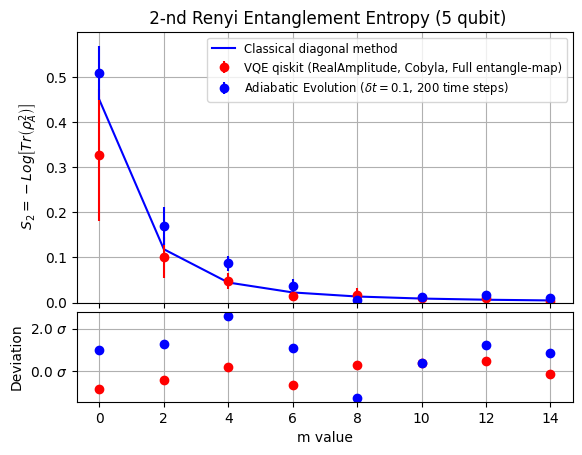

In [41]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0.05)
ax0.plot(running_list, cl_re, 'b-',label='Classical diagonal method')
ax0.errorbar(running_list, qu_mean, yerr=qu_std, fmt = 'o', color = 'red',label='VQE qiskit (RealAmplitude, Cobyla, Full entangle-map)')
ax0.errorbar(running_list, qu_mean_AE, yerr=qu_std_AE, fmt = 'o', color = 'blue',label=r'Adiabatic Evolution ($ \delta t =0.1$, 200 time steps)')

ax0.legend(loc='best', fontsize = 'small')
ax0.set_title(r' 2-nd Renyi Entanglement Entropy (5 qubit)')
ax0.set_yticks(arange(0,0.6,0.1))
ax0.set_ylim(0,0.6)
ax0.set_ylabel(r' $S_2 = -Log\left[Tr\left(\rho_A^2\right)\right]$ ')
ax0.grid()
ax1.plot(running_list, devi, 'ro')
ax1.plot(running_list, devi_AE, 'bo')
ax1.set_xlabel('m value')
# ax1.axhline(y=0,color = 'black', linestyle = 'dashed')
ax1.set_ylabel('Deviation')
fig.gca().yaxis.set_major_formatter(FormatStrFormatter(r'%.1f $\sigma$'))
ax1.grid()
plt.show()
fig.savefig('aaaaa.png')

# Adiabatic Evolution

In [235]:
# input parameters
N = 4
m = 1
x = 1
del_t = 0.1 # time interval
M = 3000 # time step

In [ ]:
Hal =  Hamil_Schw(N,m,x)

# Classical solver
w,v = linalg.eig(Hal)
# print("Eigenvectors:",v)
# print("Eigenvalues:", w)

# Find ground state and energy in ensemble solutions
minimum=w[0]
min_spot=0
for i in range(1,2**N):
    if w[i]<minimum:
        min_spot=i
        minimum=w[i]                   
groundstate = v[:,min_spot]
# print("Ground State")
# print(groundstate)
# print("Ground Energy")
# print(minimum)

In [7]:
# Evolution operator
def H_evol(qc,n,M,m,x,del_t):
    N = qc.num_qubits
    for i in range(N-1):
        m_0 = 0.1
        # Create mass terms
        qc.rz(((-1)**(i+1)*m*n/M+m_0*(1-n/M))*del_t,i)
        if i == (N-2):
            qc.rz(((-1)**(i+2)*m*n/M+m_0*(1-n/M))*del_t,i+1)
        # Create gauge terms
        if i % 2 ==0:
            for j in range(i+1):
                qc.rz(-1*del_t,j)
        for j in range(i):
            for k in range(j+1,i+1):
                qc.rzz(1*del_t,j,k)
    for i in range(N-1):
        # Create kinematic terms
        qc.rxx(x*n/M*del_t,i,i+1)
        qc.ryy(x*n/M*del_t,i,i+1)
    return qc

In [ ]:
# ground state is |1010...10>
qc = QuantumCircuit(N)
for i in range(qc.num_qubits):
    if i%2 ==1:
        qc.x(i)
# Adiabatic Evolution in time step M
for i in range(M):
    qc = H_evol(qc,i,M,m,x,del_t)

In [ ]:
state_fidelity(Statevector(qc),Statevector(groundstate))